In [1]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
# filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
filepath = 'Folds5x2_pp.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df.tail()

(9568, 5)


,AT,V,AP,RH,PE
date,,,,,
2015-03-09,16.65,49.69,1014.01,91.00,460.03
2015-03-10,13.19,39.18,1023.67,66.78,469.62
2015-03-11,31.32,74.33,1012.92,36.48,429.57
2015-03-12,24.48,69.45,1013.86,62.39,435.74
2015-03-13,21.60,62.52,1017.23,67.87,453.28


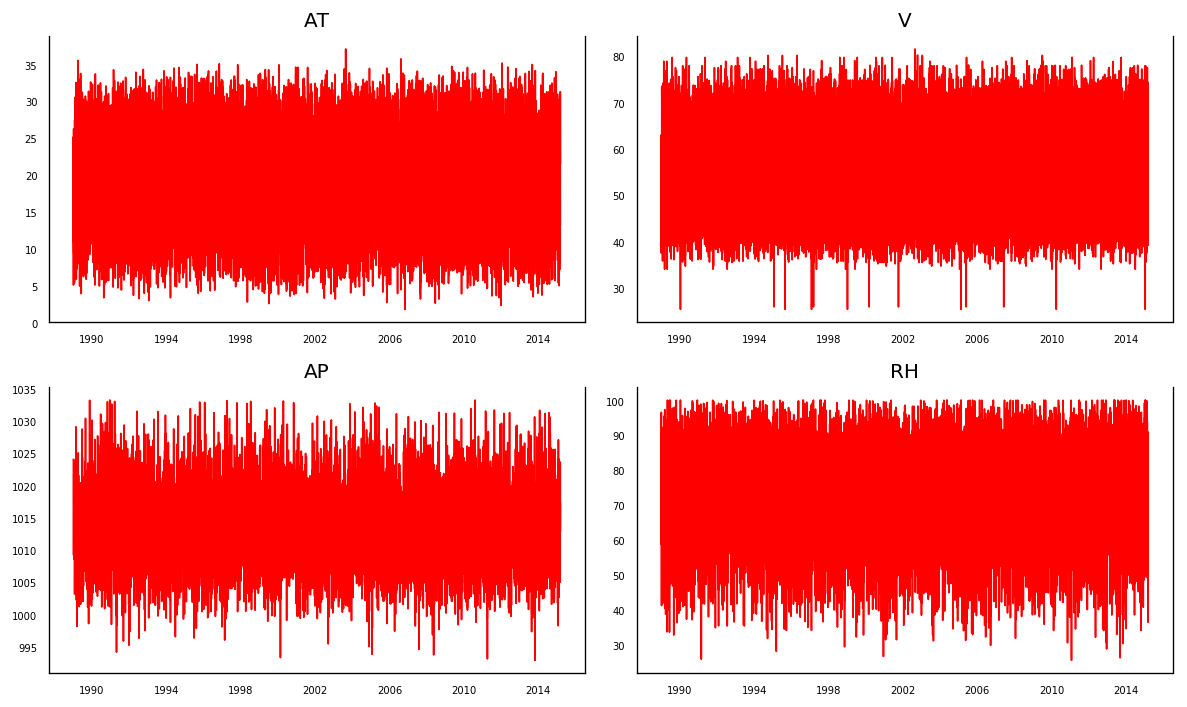

In [5]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,AT_x,V_x,AP_x,RH_x,PE_x
AT_y,1.0000,0.1865,0.3138,0.0862,0.3847
V_y,0.2621,1.0000,0.4557,0.1087,0.0859
AP_y,0.7230,0.8907,1.0000,0.1066,0.9189
RH_y,0.6612,0.6693,0.6565,1.0000,0.8058
PE_y,0.2853,0.2941,0.2671,0.1499,1.0000


In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
AT     ::  5837.27   > 60.0627   =>   True
V      ::  4299.99   > 40.1749   =>   True
AP     ::  2814.65   > 24.2761   =>   True
RH     ::  1386.97   > 12.3212   =>   True
PE     ::  0.0       > 4.1296    =>   False


In [8]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(9564, 5)
(4, 5)


In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [10]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -98.3322
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "V" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -97.4832
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [11]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [12]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.5047
 No. Lags Chosen       = 38
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "V" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.2412
 No. Lags Chosen       = 38
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [13]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [14]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "AT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -33.8935
 No. Lags Chosen       = 38
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "V" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -34.252
 No. Lags Chosen       = 38
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [15]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


AIC :  25.01452931609879
BIC :  25.037012678518263
FPE :  73058718437.217
HQIC:  25.02215680727172 

Lag Order = 2
AIC :  23.58388967309031
BIC :  23.625112880761076
FPE :  17472423555.40509
HQIC:  23.597874738329445 

Lag Order = 3
AIC :  22.697984745291606
BIC :  22.757951171889065
FPE :  7204594330.475309
HQIC:  22.718328595363694 

Lag Order = 4
AIC :  22.10303008786509
BIC :  22.18174310803767
FPE :  3973964799.031834
HQIC:  22.129733933896127 

Lag Order = 5
AIC :  21.66697487273941
BIC :  21.764437862108938
FPE :  2569494284.051801
HQIC:  21.70003992621477 

Lag Order = 6
AIC :  21.355288925241766
BIC :  21.471505260403873
FPE :  1881413210.3690307
HQIC:  21.394716398006366 

Lag Order = 7
AIC :  21.112785203026412
BIC :  21.247758261550892
FPE :  1476271340.5712411
HQIC:  21.158576307284832 

Lag Order = 8
AIC :  20.912984733002503
BIC :  21.066717893433708
FPE :  1208910039.0723326
HQIC:  20.96514068131915 

Lag Order = 9
AIC :  20.758523500944396
BIC :  20.93102014280162
FPE 

In [16]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,27.95,27.95,1.369e+12,27.95
1,25.02,25.04,7.319e+10,25.02
2,23.59,23.63,1.749e+10,23.60
3,22.70,22.76,7.205e+09,22.72
4,22.10,22.18,3.975e+09,22.13
5,21.67,21.76,2.569e+09,21.70
6,21.36,21.47,1.881e+09,21.39
7,21.11,21.25,1.477e+09,21.16
8,20.91,21.07,1.209e+09,20.96
9,20.76,20.93,1.036e+09,20.82


In [17]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Jul, 2020
Time:                     11:58:04
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    22.1817
Nobs:                     9558.00    HQIC:                   22.1297
Log likelihood:          -173336.    FPE:                3.97396e+09
AIC:                      22.1030    Det(Omega_mle):     3.93059e+09
--------------------------------------------------------------------
Results for equation AT
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.001864         0.104363           -0.018           0.986
L1.AT        -1.333808         0.039330          -33.913           0.000
L1.V          0.013080         0.011766            1.112           0.266
L1.AP         0.018467

In [18]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

NameError: name 'adjust' is not defined

In [19]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ -6.2 ,  31.04, -15.7 ,  38.41, -18.24],
       [ -8.56, -45.16,  26.37,  -5.51,  29.93],
       [ 13.77,  25.22, -21.25, -19.43, -18.72],
       [  0.37,  11.07,   3.8 ,  14.47,  -9.16]])

In [20]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,AT_2d,V_2d,AP_2d,RH_2d,PE_2d
date,,,,,
2015-03-10,-8.470494,-19.381184,4.688397,-2.744512,17.317329
2015-03-11,2.935244,8.488014,-2.200893,3.642469,-7.660321
2015-03-12,1.436212,-5.715378,1.124494,-7.520847,3.022335
2015-03-13,1.179016,8.894535,-4.016172,3.194992,-5.560295


In [21]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [24]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['AT_forecast', 'V_forecast', 'AP_forecast', 'RH_forecast']]

,AT_forecast,V_forecast,AP_forecast,RH_forecast
date,,,,
2015-03-10,10.809506,39.898816,1017.148397,96.815488
2015-03-11,7.904257,38.595646,1018.085901,106.273445
2015-03-12,6.435219,31.577098,1020.147899,108.210555
2015-03-13,6.145197,33.453085,1018.193725,113.342657


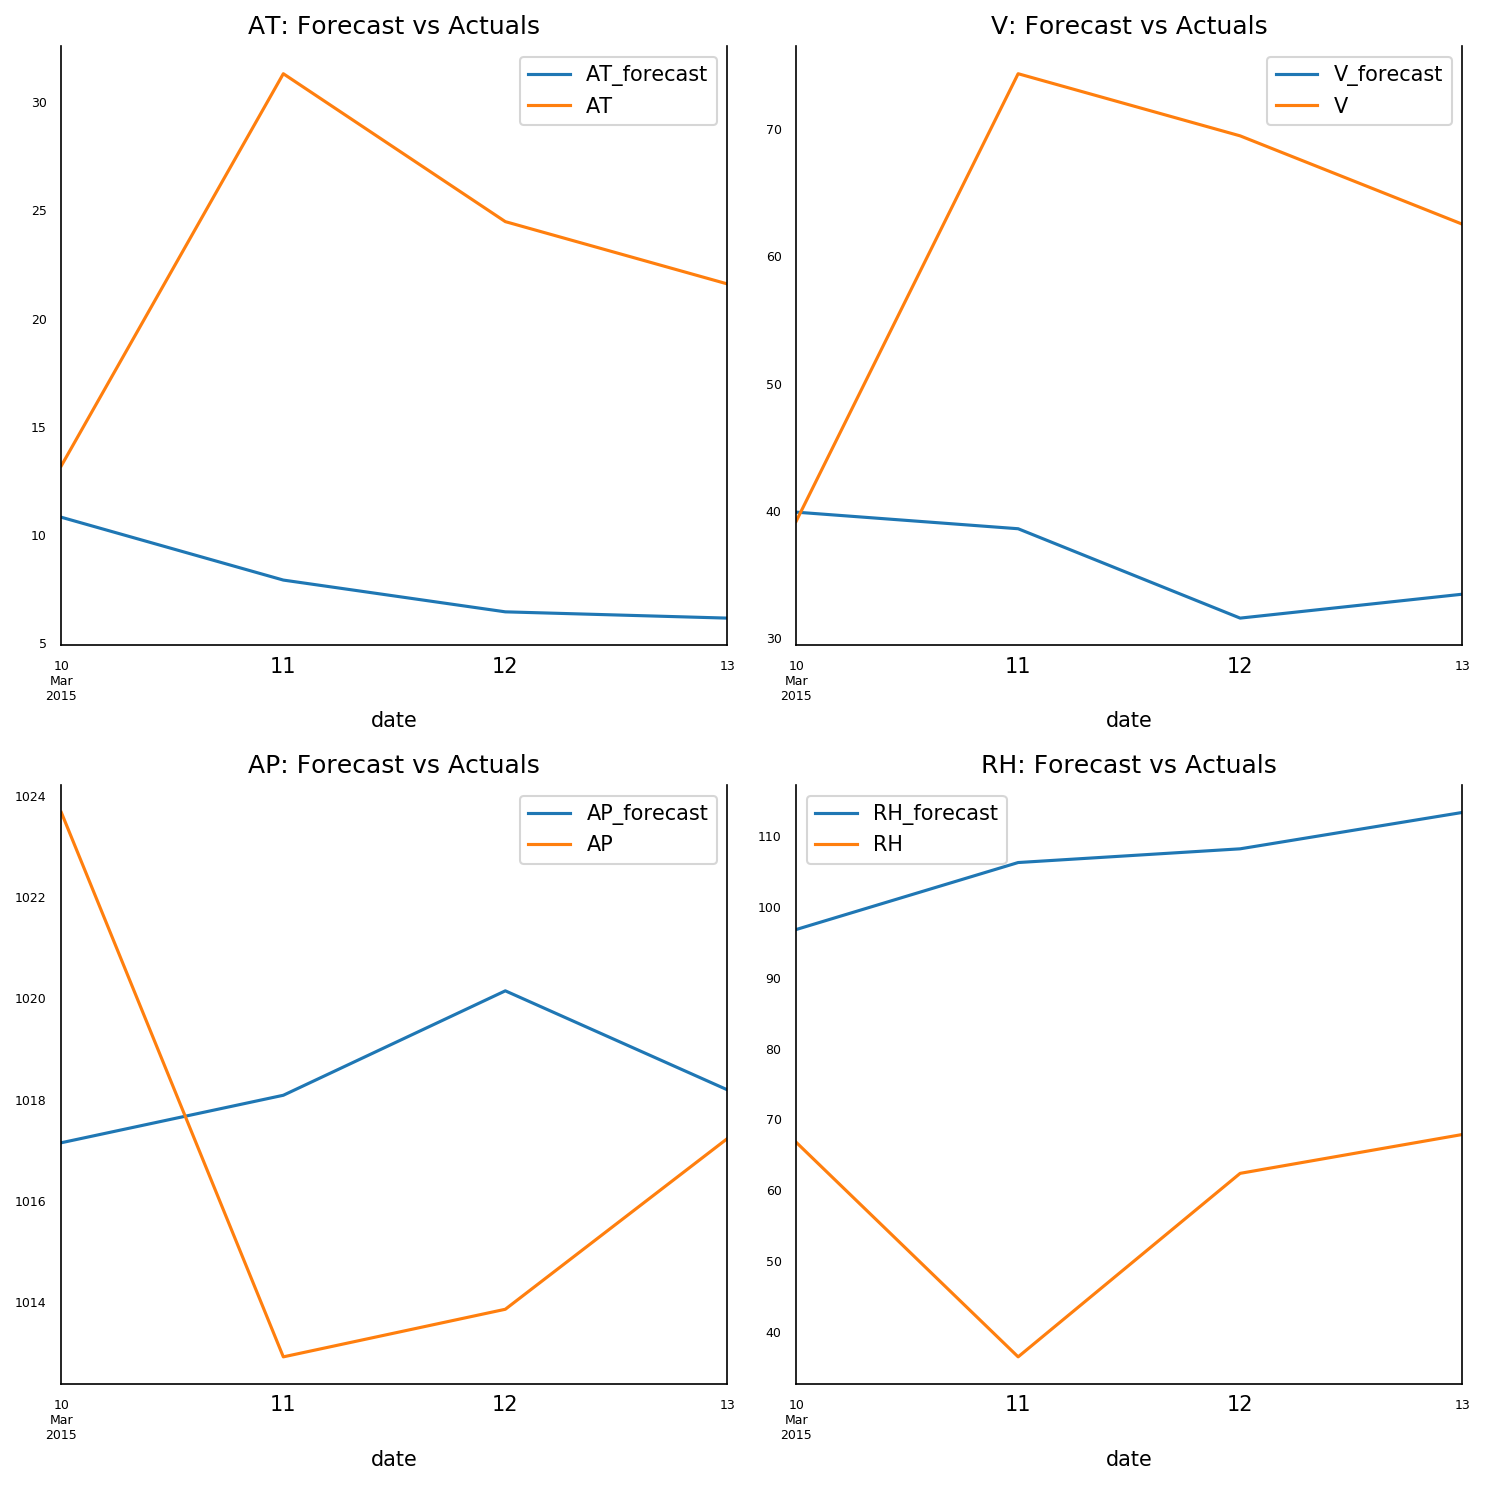

In [23]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();